https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/#comment-417989

In [1]:
%load_ext autoreload
%autoreload 2

# First step, import libraries.
import numpy as np 
import pandas as pd 
import seaborn as sb
from matplotlib import pyplot as plt
from utils import DatasetV1
%matplotlib inline

In [2]:
DATA_PATH = "../data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv"
PRED_DAYS = 30  # num prediction days for the trained models
TIME_GRAN = 10  # time granularity in minutes

### Preprare Data

 > There are 145908 rows
     Timestamp   Open   High    Low  Close  Volume_(BTC)  Volume_(Currency)  \
0   1417411980  300.0  300.0  300.0  300.0          0.01                3.0   
10  1417412580  300.0  300.0  300.0  300.0          0.01                3.0   
20  1417413180  300.0  300.0  300.0  300.0          0.01                3.0   
30  1417413780  300.0  300.0  300.0  300.0          0.01                3.0   
40  1417414380  300.0  300.0  300.0  300.0          0.01                3.0   

    Weighted_Price        Date      Time  
0            300.0  2014-12-01  05:33:00  
10           300.0  2014-12-01  05:43:00  
20           300.0  2014-12-01  05:53:00  
30           300.0  2014-12-01  06:03:00  
40           300.0  2014-12-01  06:13:00  
 Train data size 1415880
 Test data size 43200


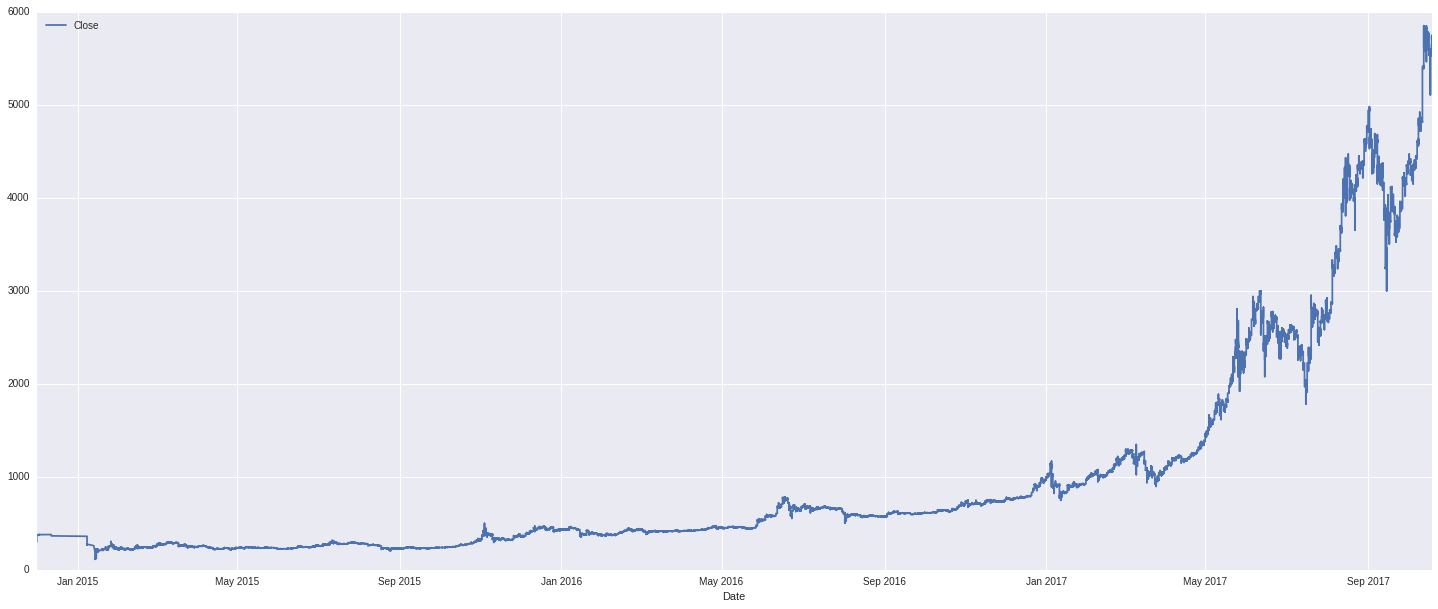

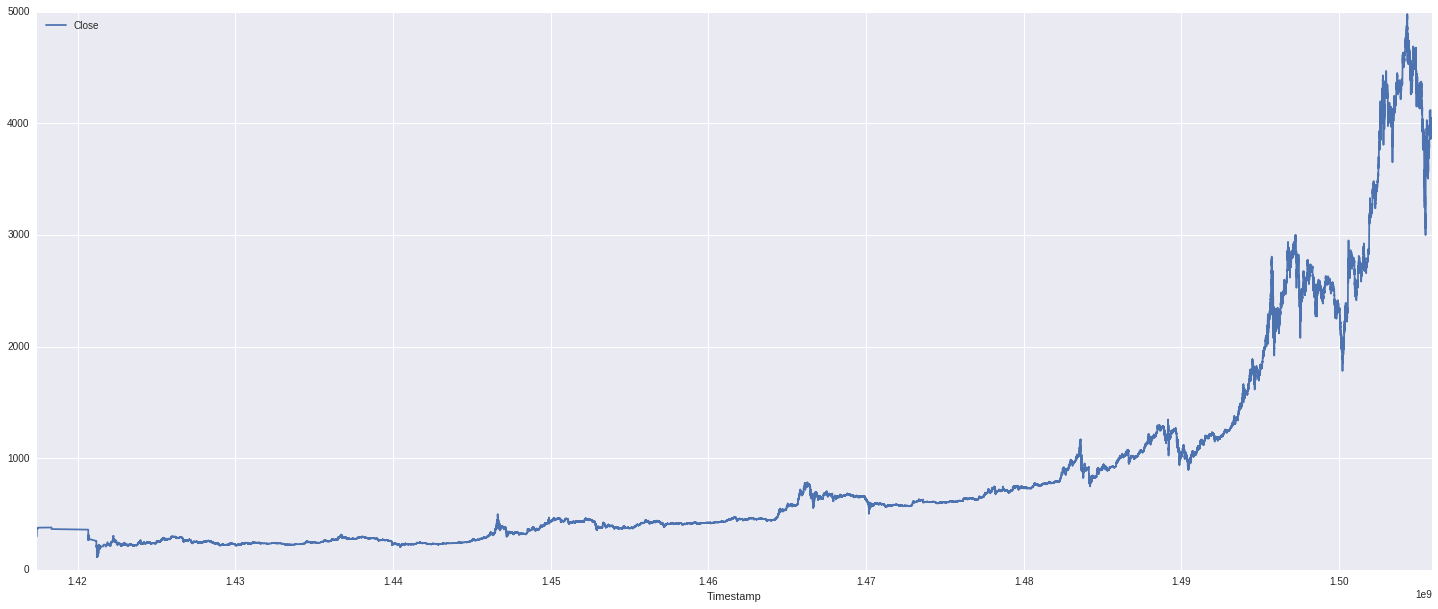

In [3]:
num_test_steps = ((24*60) / TIME_GRAN) * PRED_DAYS 
dataset = DatasetV1(DATA_PATH, tstart=num_test_steps,time_gran=10)

# plot the history
dataset.df.plot(x='Date', y='Close', figsize=[25, 10])

# split data
dataset.create_train_data_v1()

dataset.df_train.plot(x='Timestamp', y='Close', figsize=[25, 10])

### Train the model

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tqdm import tqdm

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 6, activation = 'sigmoid', input_shape = (None, 1), stateful=True, batch_input_shape=[1,1,1]))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
for i in range(50):
    print(" ---- "+str(i))
    regressor.fit(dataset.X_train[120000:], dataset.y_train[120000:], epochs=1, batch_size=1, verbose=True, shuffle=False)
    score = regressor.evaluate(dataset.X_test, dataset.y_test, batch_size=1)
    print(" > Test error:{}".format(score))
    regressor.reset_states()

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
 ---- 0
Epoch 1/1
4311/4318 [============================>.] - ETA: 0s > Test error:0.00119559953056
 ---- 1
Epoch 1/1
4310/4318 [============================>.] - ETA: 0s > Test error:0.00120275774677
 ---- 2
Epoch 1/1
4309/4318 [============================>.] - ETA: 0s > Test error:0.00120989956299
 ---- 3
Epoch 1/1
4297/4318 [============================>.] - ETA: 0s > Test error:0.0012153046513
 ---- 4
Epoch 1/1
4306/4318 [============================>.] - ETA: 0s > Test error:0.00121890487734
 ---- 5
Epoch 1/1
 3560/21586 [===>..........................] - ETA: 122s - loss: 1.5075e-04

KeyboardInterrupt: 

### Test model

#### Train data

In [5]:
from sklearn.metrics import mean_squared_error
regressor.reset_states()

# walk-forward validation on the test data
X_test = dataset.X_train[:10000]
y_test = dataset.y_train[:10000]
preds = []
labels = []
for idx, x_test in enumerate(X_test):
    # make one-step forecast
    x = x_test.reshape(1, 1, len(x_test))
    yhat = regressor.predict(x, batch_size=1)
    # store forecast
    preds.append(yhat[0][0])
    labels.append(y_test[idx])

print(" >  MSE error: {}".format(mean_squared_error(preds, labels)))

 >  MSE error: 9.12928395234e-05


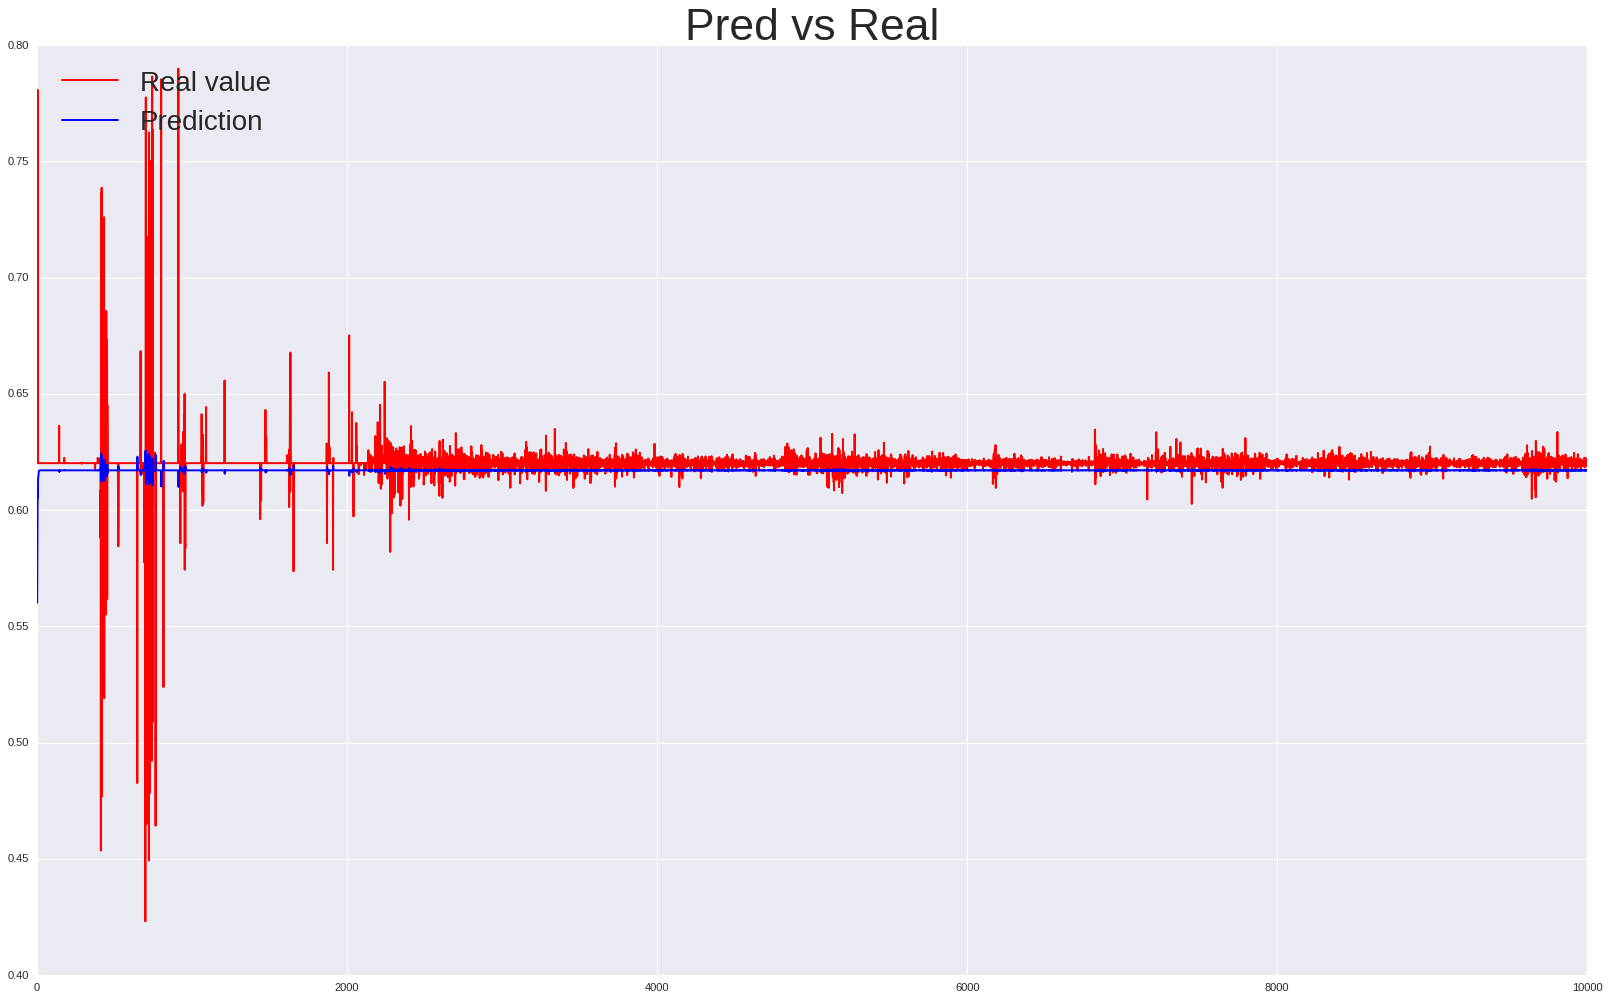

In [6]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  

plt.plot(labels, color = 'red', label = 'Real value')
plt.plot(preds, color = 'blue', label = 'Prediction')

plt.title('Pred vs Real', fontsize=40)
plt.legend(loc=2, prop={'size': 25})

#### Test data

In [7]:
from sklearn.metrics import mean_squared_error
regressor.reset_states()

# walk-forward validation on the test data
X_test = dataset.X_test
y_test = dataset.y_test
preds = []
labels = []
for idx, x_test in enumerate(X_test):
    # make one-step forecast
    x = x_test.reshape(1, 1, len(x_test))
    yhat = regressor.predict(x, batch_size=1)
    # store forecast
    preds.append(yhat[0][0])
    labels.append(y_test[idx])

print(" >  MSE error: {}".format(mean_squared_error(preds, labels)))

 >  MSE error: 0.00121257700692


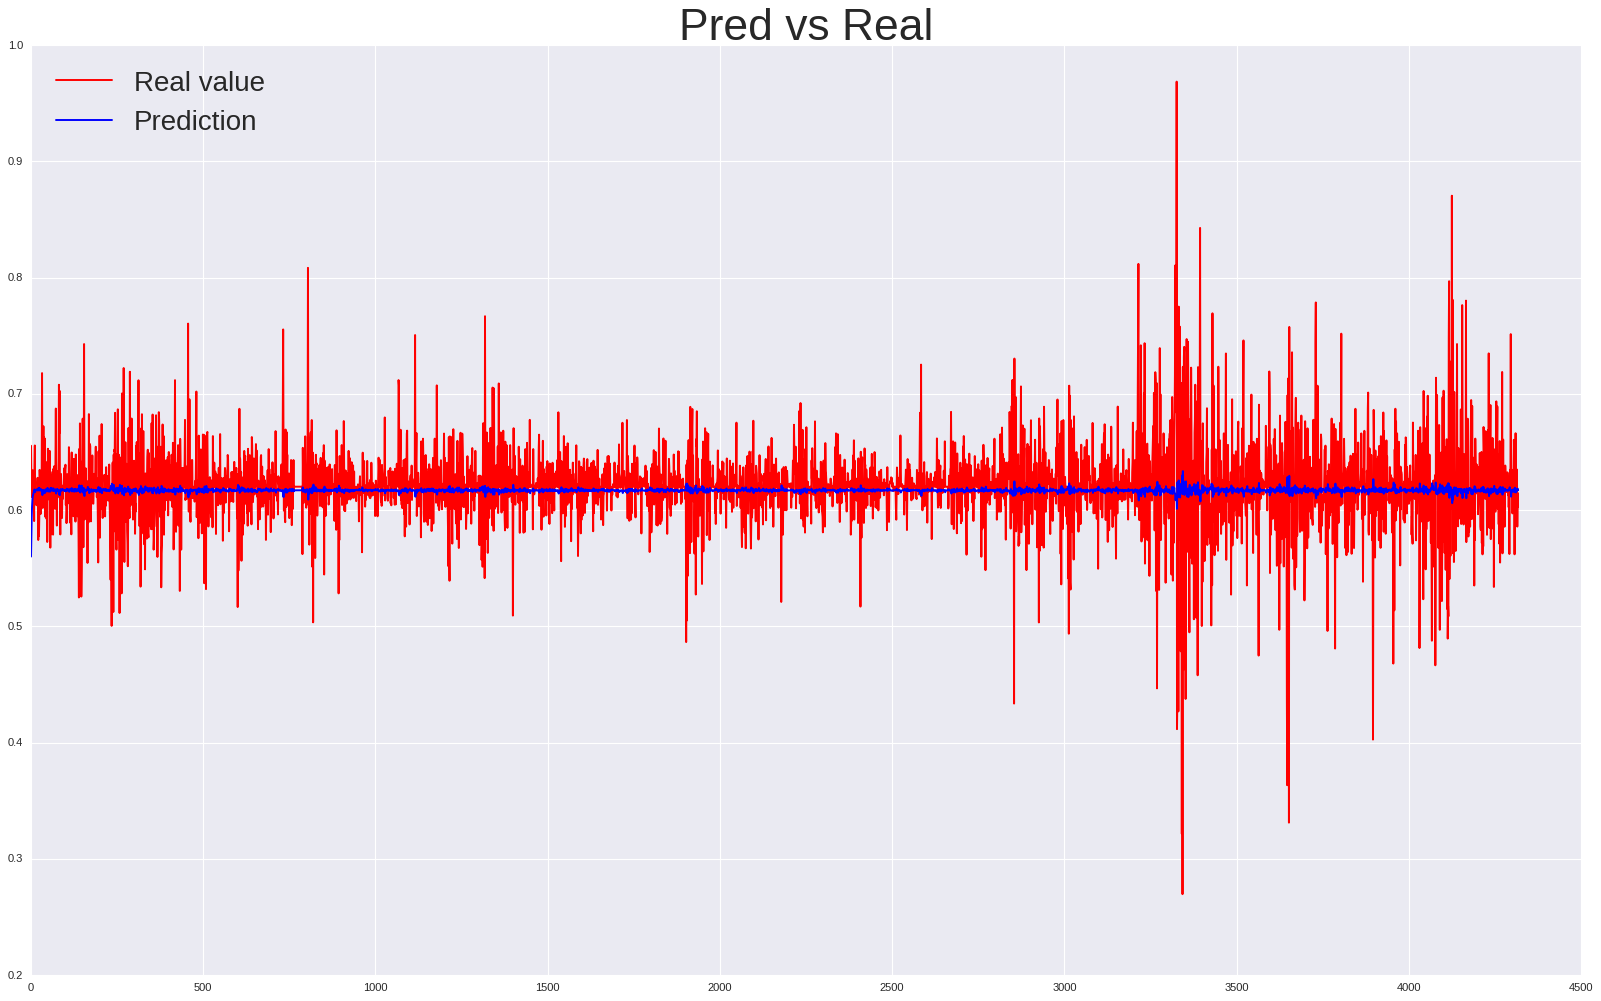

In [8]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  

plt.plot(labels, color = 'red', label = 'Real value')
plt.plot(preds, color = 'blue', label = 'Prediction')

plt.title('Pred vs Real', fontsize=40)
plt.legend(loc=2, prop={'size': 25})